# EPA1361 - Model-Based Decision Making
# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |

* Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment
  

* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 

* *hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply slice for 1:50 and 1:250.

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time 

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging)

#added/changed 
from ema_workbench import MultiprocessingEvaluator, perform_experiments, SequentialEvaluator, IpyparallelEvaluator
#from ema_workbench.em_framework.evaluators import SOBOL, MORRIS #,LHS
from ema_workbench import Samplers 
from ema_workbench.analysis import plotting, plotting_util 

## end added 

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

def pred_prey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, 
             final_time=365, reps=1):

    #Initial values
    predators = np.zeros((reps, int(final_time/dt)+1))
    prey = np.zeros((reps, int(final_time/dt)+1))
    sim_time = np.zeros((reps, int(final_time/dt)+1))
    
    for r in range(reps):

        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

    #Calculate the time series
    for t in range(0, sim_time.shape[1]-1):

        dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
        dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

        prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
        predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
        sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

In [2]:
model = Model('PredPrey', function=pred_prey)

model.uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                       RealParameter('predation_rate', 0.0005, 0.003),
                       RealParameter('predator_efficiency', 0.001, 0.004),
                       RealParameter('predator_loss_rate', 0.04, 0.08)
                      ]

# specify outcomes
model.outcomes = [
    TimeSeriesOutcome('TIME', function=np.squeeze),
    TimeSeriesOutcome('predators', function=np.squeeze),
    TimeSeriesOutcome('prey', function=np.squeeze),]

#specify constants 
#model_python.constants

In [3]:
N = 1000
D = 4
N_scenarios = N*(2*D+D)

In [4]:
ema_logging.log_to_stderr(ema_logging.INFO)

#from SALib.analyze import sobol
#from ema_workbench.em_framework.salib_samplers import get_SALib_problem

start_seq = time.time()

with SequentialEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(scenarios = N, uncertainty_sampling=Samplers.SOBOL)
    
end_seq = time.time()
time_sequential = end_seq - start_seq
print(time_sequential) 

/opt/anaconda3/lib/python3.9/site-packages/SALib/sample/saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)
[MainProcess/INFO] performing 10000 scenarios * 1 policies * 1 model(s) = 10000 experiments
100%|███████████████████████████████████| 10000/10000 [00:37<00:00, 269.28it/s]
[MainProcess/INFO] experiments finished


37.20106911659241


In [5]:
experiments, outcomes = results 

In [6]:
outcomes_50 = outcomes.copy() 
outcomes_250 = outcomes.copy() 

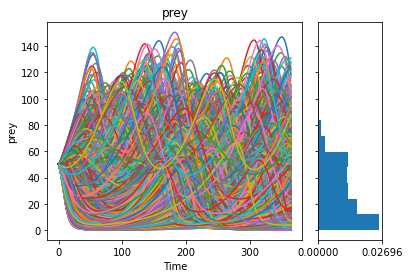

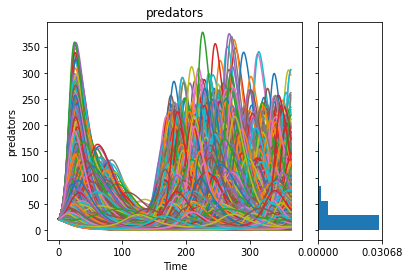

In [7]:
for outcome in ['prey','predators']:#outcomes_python.keys():
    plotting.lines(experiments, outcomes, outcomes_to_show=outcome, 
                   density=plotting_util.Density.HIST)
plt.show()

In [8]:
outcomes

{'TIME': array([[0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02, 3.6475e+02,
         3.6500e+02],
        [0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02, 3.6475e+02,
         3.6500e+02],
        [0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02, 3.6475e+02,
         3.6500e+02],
        ...,
        [0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02, 3.6475e+02,
         3.6500e+02],
        [0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02, 3.6475e+02,
         3.6500e+02],
        [0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02, 3.6475e+02,
         3.6500e+02]]),
 'predators': array([[20.        , 20.24279785, 20.4905184 , ..., 14.72805463,
         14.88876221, 15.05286001],
        [20.        , 20.24279785, 20.48677593, ..., 25.54263274,
         25.81948194, 26.09547342],
        [20.        , 20.59362793, 21.20820919, ...,  1.78570289,
          1.77256859,  1.75960613],
        ...,
        [20.        , 19.97111816, 19.94126279, ...,  9.17572566,
   

In [9]:
outcomes_50_TIME = outcomes['TIME'][0:50]
outcomes_50_TIME

array([[0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02, 3.6475e+02,
        3.6500e+02],
       [0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02, 3.6475e+02,
        3.6500e+02],
       [0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02, 3.6475e+02,
        3.6500e+02],
       ...,
       [0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02, 3.6475e+02,
        3.6500e+02],
       [0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02, 3.6475e+02,
        3.6500e+02],
       [0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02, 3.6475e+02,
        3.6500e+02]])

In [10]:
experiments[0:50]

,predation_rate,predator_efficiency,predator_loss_rate,prey_birth_rate,scenario,policy,model
0,0.000504,0.002129,0.057910,0.024736,0,None,PredPrey
1,0.001893,0.002129,0.057910,0.024736,1,None,PredPrey
2,0.000504,0.003533,0.057910,0.024736,2,None,PredPrey
3,0.000504,0.002129,0.049668,0.024736,3,None,PredPrey
4,0.000504,0.002129,0.057910,0.026748,4,None,PredPrey
5,0.000504,0.003533,0.049668,0.026748,5,None,PredPrey
6,0.001893,0.002129,0.049668,0.026748,6,None,PredPrey
7,0.001893,0.003533,0.057910,0.026748,7,None,PredPrey
8,0.001893,0.003533,0.049668,0.024736,8,None,PredPrey
9,0.001893,0.003533,0.049668,0.026748,9,None,PredPrey


In [12]:

outcomes_50['TIME'] = outcomes['TIME'][0:50]#outcomes_50_TIME
outcomes_50['prey'] = outcomes['prey'][0:50]
outcomes_50['predators'] = outcomes['predators'][0:50]

outcomes_50

{'TIME': array([[0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02, 3.6475e+02,
         3.6500e+02],
        [0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02, 3.6475e+02,
         3.6500e+02],
        [0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02, 3.6475e+02,
         3.6500e+02],
        ...,
        [0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02, 3.6475e+02,
         3.6500e+02],
        [0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02, 3.6475e+02,
         3.6500e+02],
        [0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.6450e+02, 3.6475e+02,
         3.6500e+02]]),
 'predators': array([[20.        , 20.24279785, 20.4905184 , ..., 14.72805463,
         14.88876221, 15.05286001],
        [20.        , 20.24279785, 20.48677593, ..., 25.54263274,
         25.81948194, 26.09547342],
        [20.        , 20.59362793, 21.20820919, ...,  1.78570289,
          1.77256859,  1.75960613],
        ...,
        [20.        , 20.61237793, 21.23536125, ...,  0.42879389,
   

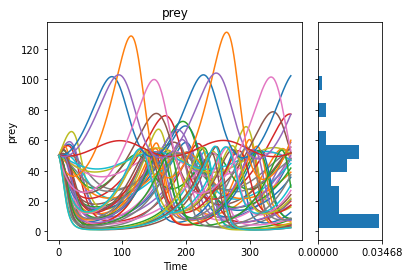

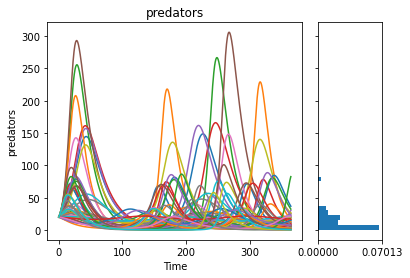

In [13]:
for outcome in ['prey','predators']:#outcomes_python.keys():
    plotting.lines(experiments, outcomes_50, outcomes_to_show=outcome, 
                   density=plotting_util.Density.HIST)
plt.show()

In [ ]:
## random from examples 

def analyze(results, ooi):
    """analyze results using SALib sobol, returns a dataframe"""

    _, outcomes = results

    problem = get_SALib_problem(model.uncertainties)
    y = outcomes[ooi]
    sobol_indices = sobol.analyze(problem, y)
    sobol_stats = {
        key: sobol_indices[key] for key in ["ST", "ST_conf", "S1", "S1_conf"]
    }
    sobol_stats = pd.DataFrame(sobol_stats, index=problem["names"])
    sobol_stats.sort_values(by="ST", ascending=False)
    s2 = pd.DataFrame(
        sobol_indices["S2"], index=problem["names"], columns=problem["names"]
    )
    s2_conf = pd.DataFrame(
        sobol_indices["S2_conf"], index=problem["names"], columns=problem["names"]
    )

    return sobol_stats, s2, s2_conf

sobol_stats, s2, s2_conf = analyze(results, "prey")
print(sobol_stats)
print(s2)
print(s2_conf)